### Spoken Language Processing
В этом задании предлагается обучить классификатор класса возраста по голосу (пример с тем, как это можно сделать для пола см. в семинаре)

Подумайте, как лучше предсказывать возраст (может быть разбить на группы?) и какой лосс использовать

In [ ]:
!pip3 install timit-utils==0.9.0
!pip3 install torchaudio
! wget https://ndownloader.figshare.com/files/10256148
!unzip -q 10256148

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5889 sha256=bf8d662b5c88b114d99f835d0953009a1114bbe681b495e49df0d20e57dcc110
  Stored in directory: /root/.cache/pip/wheels/5b/60/87/28af2605138deac93d162904df42b6fdda1dab9b8757c62aa3
Successfully built python-speech-features
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-02-04 19:41:32--  https://ndownloader.figshare.com/files/10256148
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 54.217.124.219, 52.16.102.173, 2a05:d018:1f4:d003:1c8b:1823:acce:812, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|54.217.124.219|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/10256148

In [ ]:
import timit_utils as tu
import os
import librosa
import numpy as np
import random
import math
from tqdm.notebook import tqdm
import gc
from IPython.display import clear_output

import torch as t
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torchaudio import transforms as tt

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import IPython
_TIMIT_PATH = 'data/lisa/data/timit/raw/TIMIT'


In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
t.manual_seed(SEED)
t.cuda.manual_seed(SEED)
t.backends.cudnn.deterministic = True

## Задание 1
Загрузите данные для обучения. Для этого:
1. Скачайте датасет TIMIT (см семинар)
2. Соберите пары "голос"  — "класс возраста" также, как на семинаре собирались пары "голос"  — "пол". Аудиодорожки сконвертируйте в мелспектрограммы при помощи `torchaudio либо` `librosa`

**Решение:** baseline изменен следующим образом:
 - изменен метод `clasterize_by_age`
 - дописан функционал расчета весов класса
 - дописан функционал возврата истинного возраста (для анализа ошибок модели)
 - Написан полностью другой dataloader

In [ ]:
class timit_dataloader:
    def __init__(self, data_path=_TIMIT_PATH, train_mode=True, age_mode=True):
        self.doc_file_path = os.path.join(data_path, 'DOC', 'SPKRINFO.TXT')
        self.corpus = tu.Corpus(data_path)
        self.mode_class_dct = {
            'train': [0, 0, 0],
            'valid': [0, 0, 0],
            'test': [0, 0, 0]
        }
        with open(self.doc_file_path) as f:
            self.id_age_dict = dict(
                [(tmp.split(' ')[0], 86 - int(tmp.split('  ')[5].split('/')[-1].replace('??', '50'))) \
                 for tmp in f.readlines()[39:]])
        if train_mode:
            self.trainset = self.create_dataset('train', age_mode=age_mode)
            self.validset = self.create_dataset('valid', age_mode=age_mode)
        self.testset = self.create_dataset('test', age_mode=age_mode)

    def return_age(self, id):
        return self.id_age_dict[id]

    def return_data(self):
        return self.trainset, self.validset, self.testset

    def return_test(self):
        return self.testset

    def create_dataset(self, mode, age_mode=False):
        global people
        assert mode in ['train', 'valid', 'test']
        if mode == 'train':
            people = [self.corpus.train.person_by_index(i) for i in range(350)]
        if mode == 'valid':
            people = [self.corpus.train.person_by_index(i) for i in range(350, 400)]
        if mode == 'test':
            people = [self.corpus.test.person_by_index(i) for i in range(150)]
        spectrograms_and_targets = []
        for person in tqdm(people):
              try:
                  target = self.return_age(person.name)
                  self.mode_class_dct[mode][self.clasterize_by_age(target)] += 1
                  for i in range(len(person.sentences)):
                      spectrograms_and_targets.append(
                          self.preprocess_sample(person.sentence_by_index(i).raw_audio, target, age_mode=True))
              except:
                  print(person.name, target)

        X, age, y = map(np.stack, zip(*spectrograms_and_targets))
        return X, y, age

    @staticmethod
    def spec_to_image(spec, eps=1e-6):
        mean = spec.mean()
        std = spec.std()
        spec_norm = (spec - mean) / (std + eps)
        spec_min, spec_max = spec_norm.min(), spec_norm.max()
        spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
        spec_scaled = spec_scaled.astype(np.uint8)
        return spec_scaled

    @staticmethod
    def clasterize_by_age(age):
        if age < 25:
            return 0
        if 25 <= age <= 40:
            return 1
        if age > 40:
            return 2

    def return_class_weights(self, mode):
        assert mode in ['train', 'valid', 'test']
        lst_class = self.mode_class_dct[mode]
        return sum(lst_class) / (len(lst_class) * np.array(lst_class))

    def preprocess_sample(self, amplitudes, target, age_mode=False, sr=16000, max_length=150):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        target_class = self.clasterize_by_age(target)
        return self.spec_to_image(np.float32(spectrogram)), target, target_class

    def preprocess_sample_inference(self, amplitudes, sr=16000, max_length=150, device='cpu'):
        spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr, n_mels=128, fmin=1, fmax=8192)[:, :max_length]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
        spectrogram = np.array([self.spec_to_image(np.float32(spectrogram))])
        return t.tensor(spectrogram, dtype=t.float).to(device, non_blocking=True)


# # Не будем использовать Dataloader из семинара, напишем свой
# class dataloader:
#     def __init__(self, spectrograms, targets):
#         self.data = list(zip(spectrograms, targets))

#     def next_batch(self, batch_size, device):
#         indices = np.random.randint(len(self.data), size=batch_size)

#         input = [self.data[i] for i in indices]

#         source = [line[0] for line in input]
#         target = [line[1] for line in input]

#         return self.torch_batch(source, target, device)

#     '@staticmethod
#     def torch_batch(source, target, device):
#         return tuple(
#             [
#                 t.tensor(val, dtype=t.float).to(device, non_blocking=True)
#                 for val in [source, target]
#             ]
#         )

#     '@staticmethod
#     def padd_sequences(lines, pad_token=0):
#         lengths = [len(line) for line in lines]
#         max_length = max(lengths)

#         return np.array(
#             [
#                 line + [pad_token] * (max_length - lengths[i])
#                 for i, line in enumerate(lines)
#             ]
#         )

In [ ]:
class DataLoader():
    def __init__(self, spectrograms, targets, ages, batch_size, mode=None, shuffle=True, device=t.device('cpu')):
        self.inputs = spectrograms
        self.targets = targets
        self.ages = ages
        self.num_samples = len(targets)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.batches_count = int(math.ceil(self.num_samples / batch_size))
        self.device = device
        self.timemask = tt.TimeMasking(time_mask_param=5, p=0.9)
        self.freqmask = tt.FrequencyMasking(freq_mask_param=4)
        self.mode = mode

    def __len__(self):
        return self.batches_count

    def __iter__(self):
        indices = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(indices)

        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            batch_indices = indices[start:end]
            inputs = t.tensor(self.inputs[batch_indices], dtype=t.float)

            # augmentations (only for training)
            if self.mode:
                aug_iters = np.random.choice(10, 2)
                for _ in range(aug_iters[0]):
                  inputs = self.timemask(inputs)
                for _ in range(aug_iters[0]):
                  inputs = self.freqmask(inputs)

            outputs = self.targets[batch_indices]
            true_ages = self.ages[batch_indices]

            yield {
                'inputs': inputs.to(device, non_blocking=True),
                'outputs': t.tensor(outputs, dtype=t.long).to(device, non_blocking=True),
                'true_ages': t.tensor(true_ages, dtype=t.long).to(device, non_blocking=True)
            }

In [ ]:
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
_timit_dataloader = timit_dataloader()
train_set, valid_set, test_set = _timit_dataloader.return_data()

trainset = DataLoader(train_set[0], train_set[1], train_set[2], 64, mode='train', shuffle=True, device=device)
validset = DataLoader(valid_set[0], valid_set[1], valid_set[2], 64, shuffle=False, device=device)
testset = DataLoader(test_set[0], test_set[1], test_set[2], 64, shuffle=False, device=device)

  0%|          | 0/350 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# Посчитаем веса классов
class_weights = t.tensor(_timit_dataloader.return_class_weights('train'), dtype=t.float32, device=device)
class_weights

tensor([2.0115, 0.4630, 2.9167], device='cuda:0')

#Задание 2
1. Обучите свой классификатор категории возраста
2. Попробуйте улучшить результат. Можно попробовать усложнить сетку, подвигать границы категорий, поискать новые данные, что угодно, кроме учиться на тесте :)
3. Какой подход оказался самым эффективным? Как думаете, почему?
4. Как считаете, где можно было бы применить такой классификатор в качестве вспомогательной задачи?


(baseline) Простая сверточная сеть, ее можно дотюнить или поменять по желанию

**Решение:** baseline изменен и дополнен следующим образом:
- Переписаны fc-слой и метод `forward` в BaseModel (теперь forward возвращает logits на 3 класса)
- Написан более грубокий классифкатор для сравнения итого качества
- Написаны функции для обучения и инференса моделей

Выводы содержат ответы на вопросы 3 и 4 и сравнение двух моделей (baseline и улучшенной)

In [ ]:
# Будем сохранять веса моделей на диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd ./drive/MyDrive/DLS_NLP/8w_audio/

/content/drive/MyDrive/DLS_NLP/8w_audio


In [ ]:
# Baseline
import torch

class BaseModel(nn.Module):
    def __init__(self, window_sizes=(3, 4, 5)):
        super(BaseModel, self).__init__()

        self.convs = nn.ModuleList([
            nn.Conv2d(1, 128, [window_size, 128], padding=(window_size - 1, 0))
            for window_size in window_sizes
        ])

        self.fc = nn.Linear(128 * len(window_sizes), 3)

    def forward(self, x):
        x = x.permute(0, 2, 1).unsqueeze(1)  # [B, 128, 150] -> [B, 1, 150, 128] Add a channel dim.
        xs = []
        for conv in self.convs:
            x2 = F.relu(conv(x))  # [B, F, T, 1]
            x2 = torch.squeeze(x2, -1)  # [B, F, T]
            x2 = F.max_pool1d(x2, x2.size(2))  # [B, F, 1]
            xs.append(x2)
        x = torch.cat(xs, 2)  # [B, F, window]

        # FC
        x = x.view(x.size(0), -1)  # [B, F * window]
        logits = self.fc(x)  # [B, class]
        return logits

In [ ]:
# Направленная модель (без конкатенации)
import torch
import torch.nn as nn

class DirectCNNModel(nn.Module):
    def __init__(self):
        super(DirectCNNModel, self).__init__()

        self.conv = nn.Sequential(
             # (B, 1, 150, 128)
            nn.Conv2d(1, 128, 4, padding=2),
            nn.BatchNorm2d(128),
            nn.ELU(),

             # (B, 128, 151, 129)
            nn.Conv2d(128, 128, 4, padding=2),
            nn.BatchNorm2d(128),
            nn.ELU(),
             # (B, 128, 152, 130)
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

             # (B, 128, 76, 65)
            nn.Conv2d(128, 256, 4, padding=(2,1)),
            nn.BatchNorm2d(256),
            nn.ELU(),
              # (B, 256, 77, 64)
            nn.MaxPool2d(kernel_size=2, stride=2, padding=(1,0)),

             # (B, 256, 39, 32)
            nn.Conv2d(256, 64, 4, padding=1),
            nn.BatchNorm2d(64),
            nn.ELU(),
             # (B, 256, 38, 31)
            nn.MaxPool2d(kernel_size=2, stride=2, padding=(0,1))
            # out (B, 64, 19, 16)
        )

        self.fc = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Dropout(0.2),
            nn.Linear(64 * 19 * 16, 512),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(512, 3)
        )

    def forward(self, x):
        x = torch.unsqueeze(x, 1)  # [B, C, T, E] Add a channel dim
        x = self.conv(x) # [B, 64, 19, 16]
        logits = self.fc(x) # [B, 3]
        return logits

### Функции обучения

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
import math
import time

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None, train_f1_hist=None, valid_f1_hist=None, train_acc_hist=None, valid_acc_hist=None):
    model.train()
    history = []

    epoch_loss = 0
    epoch_truelables = torch.Tensor()
    epoch_preds = torch.Tensor()
    for i, batch in enumerate(iterator):
        optimizer.zero_grad()
        input = batch["inputs"].to(device)
        labels = batch["outputs"].to(device)
        output = model(input)

        loss = criterion(output, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
        output = torch.argmax(output.detach().cpu(), dim=1)
        epoch_preds = torch.cat((epoch_preds, output))
        epoch_truelables = torch.cat((epoch_truelables, labels.cpu()))

        history.append(loss.cpu().data.numpy())

    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(25, 8))
    clear_output(True)
    ax[0].plot(history, label='train loss')
    ax[0].set_xlabel('Batch')
    ax[0].set_title('Train loss')
    ax[0].legend()
    if train_history is not None:
        ax[1].plot(train_history, label='general train history')
        ax[1].set_xlabel('Epoch')
        ax[1].legend()
    if valid_history is not None:
        ax[1].plot(valid_history, label='general valid history')
        ax[1].legend()
    if train_f1_hist is not None:
        ax[2].plot(train_f1_hist, label='train f1 history')
        ax[2].set_xlabel('Epoch')
        ax[2].legend()
    if valid_f1_hist is not None:
        ax[2].plot(valid_f1_hist, label='valid f1 history')
        ax[2].legend()
    if train_acc_hist is not None:
        ax[3].plot(train_acc_hist, label='train accuracy history')
        ax[3].set_xlabel('Epoch')
        ax[3].legend()
    if valid_acc_hist is not None:
        ax[3].plot(valid_acc_hist, label='valid accuracy history')
        ax[3].legend()
    plt.show()

    return epoch_loss / (i + 1), epoch_truelables.to(torch.int64).numpy(), epoch_preds.numpy()


def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_truelables = torch.Tensor()
    epoch_preds = torch.Tensor()

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            input = batch["inputs"].to(device)
            labels = batch["outputs"].to(device)
            output = model(input)

            loss = criterion(output, labels)

            epoch_loss += loss.item()
            output = torch.argmax(output.detach().cpu(), dim=1)
            epoch_preds = torch.cat((epoch_preds, output))
            epoch_truelables = torch.cat((epoch_truelables, labels.cpu()))

    return epoch_loss / (i + 1), epoch_truelables.to(torch.int64).numpy(), epoch_preds.numpy()


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def inference(model, test_loader):
    truelables = torch.Tensor()
    preds = torch.Tensor()
    model.eval()
    with torch.no_grad():
      for batch in tqdm(test_loader):
        input = batch["inputs"].to(device)
        labels = batch["outputs"].to(device)
        output = model(input)
        output = torch.argmax(output.detach().cpu(), dim=1)
        preds = torch.cat((preds, output))
        truelables = torch.cat((truelables, labels.cpu()))

    test_f1 = f1_score(truelables.to(torch.int64).numpy(), preds.numpy(), average='weighted')
    print(f'F1-score on test dataset: {test_f1:.3f}')
    test_acc = accuracy_score(truelables.to(torch.int64).numpy(), preds.numpy())
    print(f'Accuracy score on test dataset: {test_acc:.3f}')

In [ ]:
def train_model(model, model_name, train_loader, valid_loader, optimizer, criterion, clip, N_EPOCHS):
    train_history = []
    valid_history = []
    train_f1_hist = []
    valid_f1_hist = []
    train_acc_hist = []
    valid_acc_hist = []

    best_valid_loss = float('inf')
    best_valid_f1 = 0

    for epoch in range(N_EPOCHS):
        start_time = time.time()

        train_loss, train_truelables, train_preds = train(model, train_loader, optimizer, criterion, clip, train_history, valid_history, train_f1_hist, valid_f1_hist, train_acc_hist, valid_acc_hist)
        valid_loss, valid_truelables, valid_preds = evaluate(model, valid_loader, criterion)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'best-loss-{model_name}.pt')

        train_f1 = f1_score(train_truelables, train_preds, average='weighted')
        valid_f1 = f1_score(valid_truelables, valid_preds, average='weighted')
        train_acc = accuracy_score(train_truelables, train_preds)
        valid_acc = accuracy_score(valid_truelables, valid_preds)

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        train_f1_hist.append(train_f1)
        valid_f1_hist.append(valid_f1)
        train_acc_hist.append(train_acc)
        valid_acc_hist.append(valid_acc)

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        print(f'\t Train. F1: {train_f1:.3f} |  Val. F1: {valid_f1:.3f}')
        print(f'\t Train. Acc: {train_acc:.3f} |  Val. Acc: {valid_acc:.3f}')
        gc.collect()
        torch.cuda.empty_cache()

    torch.save(model.state_dict(), f'last-{model_name}.pt')
    return model

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Обучение baseline модели

In [ ]:
model = BaseModel().to(device)
opt = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_func = nn.CrossEntropyLoss()
CLIP = 3
N_EPOCHS = 40
model_name = 'basemobel'
model.eval()

BaseModel(
  (convs): ModuleList(
    (0): Conv2d(1, 128, kernel_size=(3, 128), stride=(1, 1), padding=(2, 0))
    (1): Conv2d(1, 128, kernel_size=(4, 128), stride=(1, 1), padding=(3, 0))
    (2): Conv2d(1, 128, kernel_size=(5, 128), stride=(1, 1), padding=(4, 0))
  )
  (fc): Linear(in_features=384, out_features=3, bias=True)
)

In [ ]:
print(f'The model has {count_parameters(model)} trainable parameters')

The model has 198147 trainable parameters


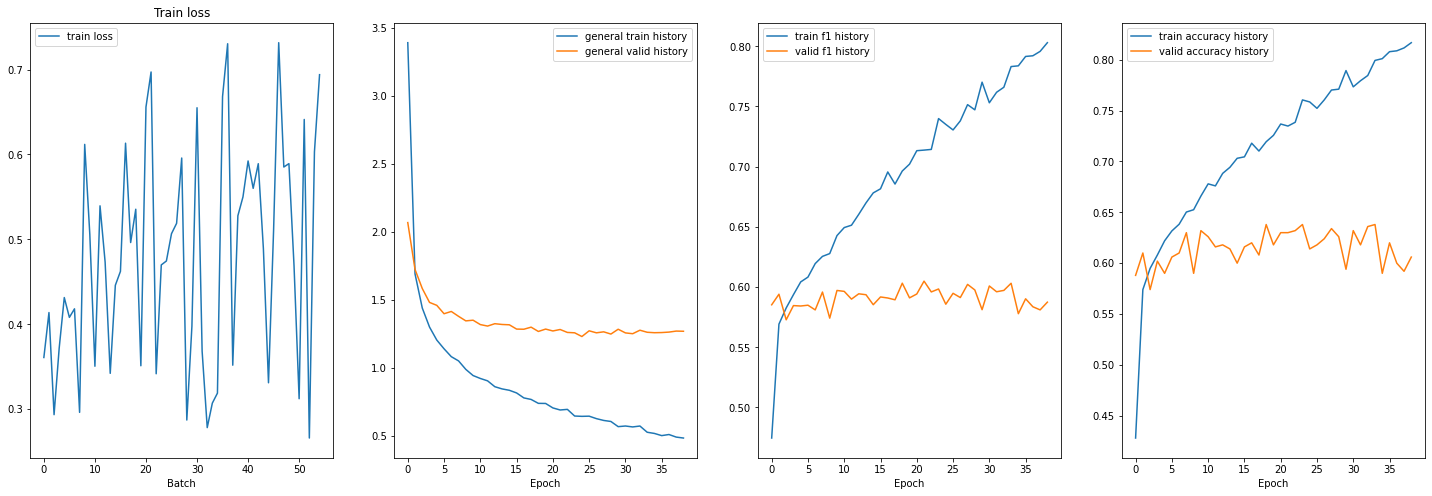

Epoch: 40 | Time: 0m 2s
	Train Loss: 0.480 | Train PPL:   1.616
	 Val. Loss: 1.260 |  Val. PPL:   3.525
	 Train. F1: 0.804 |  Val. F1: 0.597
	 Train. Acc: 0.819 |  Val. Acc: 0.648


In [ ]:
model = train_model(model, model_name, trainset, validset, opt, loss_func, CLIP, N_EPOCHS)

In [ ]:
# Посчитаем метрики на тестовой выборке
model.load_state_dict(torch.load('best-loss-basemobel.pt'))
inference(model, testset)

  0%|          | 0/24 [00:00<?, ?it/s]

F1-score on test dataset: 0.592
Accuracy score on test dataset: 0.621


### Обучение DirectCNNModel

In [ ]:
!nvidia-smi

Sat Feb  4 19:55:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    35W /  70W |   1138MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model = DirectCNNModel().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_func = nn.CrossEntropyLoss()
CLIP = 3
N_EPOCHS = 20
model_name = 'directmobel'
model.eval()

DirectCNNModel(
  (conv): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(2, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ELU(alpha=1.0)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=(1, 0), dilation=1, ceil_mode=False)
    (11): Conv2d(256, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ELU(alpha=1.0)
    (14): MaxPool2d(kerne

In [ ]:
print(f'The model has {count_parameters(model)} trainable parameters')

The model has 11015875 trainable parameters


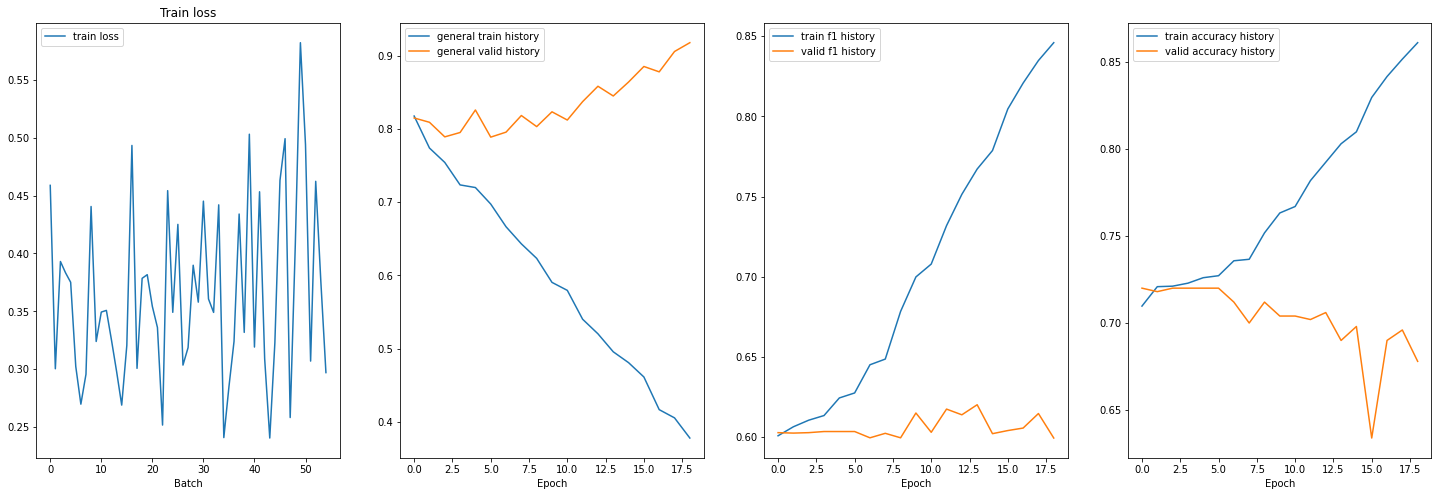

Epoch: 20 | Time: 0m 52s
	Train Loss: 0.365 | Train PPL:   1.440
	 Val. Loss: 0.911 |  Val. PPL:   2.488
	 Train. F1: 0.860 |  Val. F1: 0.604
	 Train. Acc: 0.872 |  Val. Acc: 0.676


In [ ]:
model = train_model(model, model_name, trainset, validset, opt, loss_func, CLIP, N_EPOCHS)

In [ ]:
# Посчитаем метрики на тестовой выборке
model.load_state_dict(torch.load('best-loss-directmobel.pt'))
inference(model, testset)

  0%|          | 0/24 [00:00<?, ?it/s]

F1-score on test dataset: 0.601
Accuracy score on test dataset: 0.712


### Выводы

Изменение архитектуры сети (а у меня было много разнообразных экспериментов) не дает значимого прироста в качестве классификации. Зато, увеличение доли среднего класса оказывает значительный эффект. В данном случае, можно говорить о том, что качество выборки не позволяет сделать достоверные выводы о возрасте спикеров (если это вообще возможно).

Считаю, что более правильным был следующий подход:
- Отделять детей от взрослых (между возрастом детей и возрастом взрослых должен быть "пробел")

Если бы выборка была более натуральной, можно было бы использовать другие паттерны:
- Стиль речи
- Характерные для детей / взрослых речевые конструкции